# 💬 LangGraph로 만드는 간단한 고객 응대 챗봇: 큰 흐름 설명

이 코드는 "고객이 질문 → AI가 답변 → 3턴 지나면 종료"라는 단순한 상담 챗봇 흐름을 구현한 것입니다. 아래와 같은 4단계 구조로 동작합니다:

---

### 📌 단계 1. 초기 설정
- Gemini 모델을 불러오고, API 속도 제한(초당 0.167회) 설정

### 📌 단계 2. 메시지 구성
- 대화 기록(history)을 Customer / Agent / Policy 메시지로 구분

### 📌 단계 3. 대화 흐름 정의
- 노드: 고객 질문 수집(collect_inquiry), AI 응답 생성(generate_response)
- 조건부 엣지: 턴 수가 3이면 종료(HALT), 아니면 반복(LOOP)

### 📌 단계 4. 대화 실행
- 규칙(톤)을 포함한 첫 메시지로 시작해, 턴마다 응답 생성 반복


In [2]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# ✅ 포인트: API 호출 횟수를 제어하는 장치 (초당 약 0.167회 = 분당 10회 제한)
campaign_throttle = InMemoryRateLimiter(
    requests_per_second=0.167,
    check_every_n_seconds=0.1,
    max_bucket_size=10,
)

# ✅ 포인트: Gemini 모델을 불러와서 마케팅 대화 전용 인공지능 인스턴스 생성
copy_brain = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-exp",
    rate_limiter=campaign_throttle
)

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# --- 메시지 타입/타이핑 ---
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage as CustomerMessage, SystemMessage as PolicyMessage, AIMessage as AgentMessage
# ✅ 포인트: 메시지를 고객(Customer), 정책(Policy), 상담원(AI) 형태로 구분
# --- 1) 멀티턴 기본 흐름 상태 및 노드 (ask_human → talk → check_end) ---
class SupportState(TypedDict):
    history: Annotated[list, add_messages]   # 대화 기록 저장
    turns: int                               # 현재 대화 턴 수


In [4]:
def collect_inquiry(state):
    """고객의 질문을 입력받아 history에 저장"""
    issue = input()
    print('Customer ▶', issue)
    return {'history': CustomerMessage(content=issue)}

def generate_response(state):
    """AI가 지금까지 대화 내용을 보고 응답 생성"""
    thread = state['history']
    reply = copy_brain.invoke(thread)
    print('Agent ▶', reply.content)
    state['turns'] += 1   # 턴 수 1 증가
    return {'history': reply, 'turns': state['turns']}

def stop_after_threshold_label(state):
    """✅ 포인트: 대화 턴이 3번 되면 종료"""
    return "HALT" if state['turns'] == 3 else "LOOP"

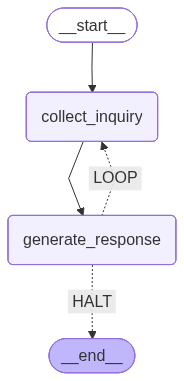

In [5]:
# ✅ 포인트: StateGraph = 대화 흐름을 '그래프 구조'로 설계
from langgraph.graph import StateGraph, START, END

customer_builder = StateGraph(SupportState)
customer_builder.add_node('collect_inquiry', collect_inquiry)   # 고객 질문 받기
customer_builder.add_node('generate_response', generate_response)   # AI 답변 생성

customer_builder.add_edge(START, 'collect_inquiry')   # 시작 → 고객 질문
customer_builder.add_edge('collect_inquiry', 'generate_response')   # 질문 → 답변
customer_builder.add_conditional_edges('generate_response',
                                       stop_after_threshold_label,
                                       {"HALT": END, "LOOP": 'collect_inquiry'})   # 종료 조건

customer_flow = customer_builder.compile()
customer_flow  # ✅ 포인트: 전체 대화 구조 미리보기

In [6]:
# 초기 규칙 프롬프트 (대화 톤 설정)
brand_tone_rules = '''고객 응대는 한 문장으로 간결하게.'''
seed_thread = [PolicyMessage(content=brand_tone_rules)]

# ✅ 실행: 첫 번째 고객 입력을 받고 대화 시작
first_run = customer_flow.invoke({'history': seed_thread, 'turns': 0})
first_run



Customer ▶ 안녕하세요
Agent ▶ 안녕하세요! 무엇을 도와드릴까요?
Customer ▶ 영업시간을 알고 싶어요
Agent ▶ 영업시간은 매일 오전 10시부터 오후 8시까지입니다.
Customer ▶ 점심시간은 언제인가요?
Agent ▶ 점심시간은 따로 없이 운영됩니다.


{'history': [SystemMessage(content='고객 응대는 한 문장으로 간결하게.', additional_kwargs={}, response_metadata={}, id='1b6d264d-8d31-482e-8059-7ea54a2c02af'),
  HumanMessage(content='안녕하세요', additional_kwargs={}, response_metadata={}, id='8fcd1b17-bb5d-47eb-8f3d-5f86abf3780c'),
  AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': []}, id='run--2c66984d-bb99-480b-b8e0-30898c0d1d26-0', usage_metadata={'input_tokens': 13, 'output_tokens': 9, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='영업시간을 알고 싶어요', additional_kwargs={}, response_metadata={}, id='061cf491-aaba-48e4-a442-69ebd83580d7'),
  AIMessage(content='영업시간은 매일 오전 10시부터 오후 8시까지입니다.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0

In [ ]:

# --- 동일 규칙으로 추가 실행 예시 ---
brand_tone_rules = '''고객 응대는 한 문장으로 간결하게.'''
seed_thread = [PolicyMessage(content=brand_tone_rules)]
customer_flow.invoke({'history': seed_thread, 'turns': 0})

# 🎭 자문자답 챗봇 시뮬레이션: 큰 틀부터 이해하기

이 코드는 AI가 '고객'과 '상담원' 역할을 번갈아 연기하며 스스로 대화하는 구조입니다.  
목표는 시뮬레이션을 통해 상담 전략을 테스트하거나 학습 데이터를 만드는 것입니다.

---

### 🔁 단계 1. 대화 흐름 만들기 (그래프 구조)
- 노드(Toll Node): `self_chat_cycle`에서 한 턴마다 AI가 말하고 역할을 교대합니다.
- 조건부 엣지(Conditional Edge): `turns`가 3 이상이면 종료(True→END), 아니면 계속(False→반복)

---

### 🗣️ 단계 2. 역할 연기 로직
- 한쪽이 말하면, 그 발화를 상대방 역할로 뒤집고 이어집니다.
- AI 스스로 질문하고 스스로 응답하며 흐름을 이어가는 것이 핵심입니다.

---

### ▶️ 단계 3. 실행
- 첫 메시지(고객 역할)를 입력받고, 시뮬레이션을 시작합니다.
- 총 3턴이 되면 자동 종료됩니다.


In [1]:
# ✅ 필요한 라이브러리
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

# ✅ 1. 상태(state) 정의
# 대화 기록, 턴 수, 화자 역할(Agent ↔ Customer)을 저장하는 구조
class SimState(TypedDict):
    history: list
    turns: int
    speaker_role: str  # "Agent" 또는 "Customer"

# ✅ 2. 대화 사이클 함수 정의
def self_chat_cycle(state):
    """AI가 고객과 상담원 역할을 번갈아 수행"""
    thread = state["history"]  # 지금까지의 대화 이력

    # ① 현재 화자(Agent/Customer)에 따라 다음 발화 생성
    reply = copy_brain.invoke(thread)  # LLM 호출
    thread.append(reply)  # 응답을 대화 이력에 추가

    # ② 콘솔 출력 (지금 말한 사람과 내용 표시)
    print(f"{state['speaker_role']} ▶ {reply.content}")

    # ③ 역할 교체 (Agent ↔ Customer)
    state["speaker_role"] = "Customer" if state["speaker_role"] == "Agent" else "Agent"

    # ④ 턴 수 증가
    state["turns"] += 1

    # ⑤ 다음 단계로 전달할 새 상태 반환
    return {"history": thread, "turns": state["turns"], "speaker_role": state["speaker_role"]}


# ✅ 3. 종료 조건 함수
def stop_after_three_turns(state):
    """3턴(왕복 3회) 되면 시뮬레이션 자동 종료"""
    return state["turns"] >= 3



/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:

# ✅ 4. 시뮬레이션 그래프 만들기
sim_builder = StateGraph(SimState)
sim_builder.add_node("self_chat_cycle", self_chat_cycle)
sim_builder.add_edge(START, "self_chat_cycle")
sim_builder.add_conditional_edges(
    "self_chat_cycle",
    stop_after_three_turns,
    {True: END, False: "self_chat_cycle"}
)
sim_flow = sim_builder.compile()


# ✅ 5. 실행 예시
brand_rule = "불만 응대는 정중하고 간결하게."  # 브랜드 말투 규칙
user_issue = input("고객이 처음 말한 문제를 입력하세요 ▶ ")

# 대화 시작 세팅
seed_history = [SystemMessage(content=brand_rule), HumanMessage(content=user_issue)]

# 실행
result = sim_flow.invoke({"history": seed_history, "turns": 0, "speaker_role": "Agent"})
print("\n🧾 시뮬레이션 종료!")
print(result)


# ✅ 6. 스트리밍 실행 (턴별 출력)
print("\n--- 대화 스트리밍 ---")
for step in sim_flow.stream({"history": seed_history, "turns": 0, "speaker_role": "Agent"}, stream_mode="values"):
    print(step)
    print("---")


# 🛠️ 툴 노드 구조: AI가 계산·날짜·뉴스 검색을 자동으로 처리하는 흐름

이 코드는 AI가 '웹 검색', '도달률 계산', '오늘 날짜 반환' 같은 툴을 **스스로 판단하여 호출**하는 구조입니다.  
마케팅 시나리오에서 실시간 정보나 수치 계산을 자동으로 처리하도록 설계되었습니다.

---

### ⚙️ 단계 1. 툴 정의
- `estimate_reach`: 고객 수 × 배율 → 예상 도달 수
- `today_stamp`: 오늘 날짜 반환
- `news_scanner`: 실시간 뉴스 검색

---

### 🔁 단계 2. 흐름 구성
- **Toll Node**: `route_with_tools`에서 AI가 툴 필요 여부 판단
- **Conditional Edge**: 툴이 필요하면 `utilities` 노드로 연결, 없으면 종료(END)

---

### ▶️ 단계 3. 실행
- 고객 메시지 입력 → AI가 판단 → 필요한 툴 실행 → 결과 응답


In [9]:
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

campaign_throttle = InMemoryRateLimiter(
    requests_per_second=0.167,
    check_every_n_seconds=0.1,
    max_bucket_size=10,
)

copy_brain = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", rate_limiter=campaign_throttle)

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.tools import tool
news_scanner = TavilySearchResults(max_results=3)   # 뉴스 검색 툴

@tool
def estimate_reach(base_audience: int, multiplier: int) -> int:
    "✅ 포인트: 기준 고객 수 × 배율 = 예상 도달 수"
    return base_audience * multiplier

@tool
def today_stamp() -> str:
    "✅ 포인트: 오늘 날짜를 YYYY-MM-DD 형식으로 반환"
    from datetime import datetime as dt
    return dt.now().strftime("%Y-%m-%d")

# 툴 단독 실행 테스트
print(estimate_reach.invoke({'base_audience': 3, 'multiplier': 4}))
print(today_stamp.invoke({}))

# ✅ 포인트: AI 모델에 툴들을 바인딩해서 자동 호출 가능
copilot = copy_brain.bind_tools([estimate_reach, today_stamp, news_scanner])  # 툴 실행 상태 관리

12
2025-12-29


/var/folders/sd/72757lvs4fx3jpxplj70p5nh0000gn/T/ipykernel_67834/356710178.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  news_scanner = TavilySearchResults(max_results=3)   # 뉴스 검색 툴


In [11]:
# ✅ LangGraph 툴 실행 기본 구성

# 필수 모듈 불러오기
from langchain_core.messages import HumanMessage, AIMessage   # 사람/AI 대화 메시지
from langgraph.prebuilt import ToolNode, tools_condition      # 툴 실행용 노드와 조건
from langgraph.graph import StateGraph, START, END            # 그래프 구조 기본 요소

# 상태 정의: 대화 메시지를 저장하는 그릇
class ToolState(TypedDict):
    messages: Annotated[list, add_messages]

# AI가 입력 메시지를 보고 응답(또는 툴 호출)을 만드는 함수
def route_with_tools(state):
    result = copilot.invoke(state["messages"])                # AI가 메시지 분석 후 응답 생성
    return {"messages": state["messages"] + [result]}         # 이전 메시지 뒤에 결과 추가


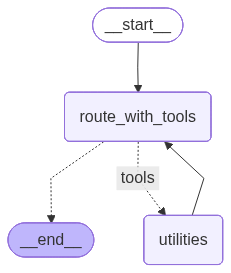

In [12]:
# ✅ LangGraph로 AI + ToolNode 흐름 구성하기 (간단 설명)

# 1️⃣ 그래프 생성 (ToolState 기반)
# 대화 내용(messages)과 툴 실행 상태를 저장할 그래프 만듦
tool_builder = StateGraph(ToolState)

# 2️⃣ 노드 추가
# - route_with_tools : AI가 메시지를 읽고 툴 호출 여부 판단
# - utilities : 실제 툴(계산, 날짜, 뉴스검색)을 실행
tool_builder.add_node("route_with_tools", route_with_tools)
tool_builder.add_node("utilities", ToolNode([estimate_reach, today_stamp, news_scanner]))

# 3️⃣ 노드 연결
# - START → route_with_tools : 대화 시작
tool_builder.add_edge(START, "route_with_tools")

# - AI가 툴 호출 요청 시 → utilities로 이동
#   아니면 종료(__end__)
tool_builder.add_conditional_edges(
    "route_with_tools", tools_condition,
    {"tools": "utilities", "__end__": END}
)

# - 툴 실행 후 다시 route_with_tools로 돌아감
tool_builder.add_edge("utilities", "route_with_tools")

# 4️⃣ 그래프 컴파일 (실행 가능한 형태로 변환)
assistant_flow = tool_builder.compile()
assistant_flow


In [13]:
# 5️⃣ 실행 예시
# 사람이 메시지를 입력하면 AI가 필요 시 툴을 자동 호출
preview = assistant_flow.invoke({
    "messages": [HumanMessage(content="기준 고객 100명, 배율 2배일 때 도달 수 계산해줘")]
})

# 6️⃣ 결과 출력 (예: AI가 estimate_reach 툴 호출 → 200 출력)
print(preview)

{'messages': [HumanMessage(content='기준 고객 100명, 배율 2배일 때 도달 수 계산해줘', additional_kwargs={}, response_metadata={}, id='38e66fc5-881a-4e53-8272-baa8709593fe'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'estimate_reach', 'arguments': '{"multiplier": 2, "base_audience": 100}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-exp', 'safety_ratings': []}, id='run--208baea8-4968-4b31-a820-6a5f7a538c6b-0', tool_calls=[{'name': 'estimate_reach', 'args': {'multiplier': 2, 'base_audience': 100}, 'id': '969241b7-5da9-4a99-8cd4-8ce5229caa9f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 120, 'output_tokens': 9, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='200', name='estimate_reach', id='95884e45-6f6f-41c8-b960-f067710beb85', tool_call_id='969241b7-5da9-4a99-8cd4-8ce5229caa9f'), AIMessage(content='예상 도달 수는 200명입니다.', additional_kwargs=

In [16]:
# --- 🤖 3) OpenAI 모델 기반 툴 실행 흐름 ---
import os
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage

# ✅ 2️⃣ OpenAI 모델 준비 (gpt-4o-mini)
copy_brain_oa = ChatOpenAI(model="gpt-4o-mini")

# ✅ 3️⃣ 동일 툴 바인딩 (웹검색 / 계산 / 날짜)
copilot_oa = copy_brain_oa.bind_tools([estimate_reach, today_stamp, news_scanner])

# ✅ 4️⃣ 상태 정의
class ToolState(TypedDict):
    messages: Annotated[list, add_messages]

# ✅ 5️⃣ 툴 호출 함수
def route_with_tools_oa(state):
    """AI가 필요한 툴을 자동 호출"""
    result = copilot_oa.invoke(state["messages"])
    return {"messages": state["messages"] + [result]}

# ✅ 6️⃣ 그래프 구성 (START → route → utilities → END)
tool_builder = StateGraph(ToolState)
tool_builder.add_node("route_with_tools", route_with_tools_oa)
tool_builder.add_node("utilities", ToolNode([estimate_reach, today_stamp, news_scanner]))
tool_builder.add_edge(START, "route_with_tools")
tool_builder.add_conditional_edges("route_with_tools", tools_condition,
                                   {"tools": "utilities", "__end__": END})
tool_builder.add_edge("utilities", "route_with_tools")

assistant_flow_oa = tool_builder.compile()

# ✅ 7️⃣ 단발 실행 예시
preview = assistant_flow_oa.invoke({
    "messages": [HumanMessage(content="오늘 날짜 기준으로 신규 리드 동향 알려줘")]
})
print(preview)

# ✅ 8️⃣ 스트리밍 실행 예시 (중간 단계 실시간 출력)
print("\n--- 스트리밍 실행 ---")
for update in assistant_flow_oa.stream(
    {"messages": [HumanMessage(content="예산 332×17 결과로 업계 기사 요약해줘")]},
    stream_mode="updates"
):
    print(update)
    print("------")

# ✅ 참고 메모
# - 같은 툴(estimate_reach, today_stamp, news_scanner)을 Gemini·OpenAI 모두 재사용 가능
# - 긴 대화(컨텍스트)는 모델 자동 요약 또는 슬라이싱 처리 권장


{'messages': [HumanMessage(content='오늘 날짜 기준으로 신규 리드 동향 알려줘', additional_kwargs={}, response_metadata={}, id='0c90f556-e2a1-4dbd-b637-63ee0a37d28c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KbyNCrPDVtmiUescyR1TXdcJ', 'function': {'arguments': '{}', 'name': 'today_stamp'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 150, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CrxsYlhhcmJJKgpXaUADvi2MnSo9T', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--739c1cac-52fe-443d-ae0e-45d678e52fe3-0', tool_calls=[{'name': 'today_stamp', 'args': {}, 'id': 'call_KbyNCrPDVtmiUescyR1TXdcJ', 'type': 